# Create Clean Trips DataFrame

## Create Station Classifier

In [1]:
import pandas as pd
import json
import os
import numpy as np
import glob

## Import Raw Station Data

In [2]:
import requests

# Set url for API call
url = 'https://gbfs.capitalbikeshare.com/gbfs/fr/station_information.json'

# Make call and set data to variable
resp = requests.get(url=url)
station_data = resp.json()

## Create Station DataFrame

In [3]:
# Parse JSON to find relevant data
station_df = pd.DataFrame.from_records(station_data['data']['stations'])

In [4]:
station_df.head()

,capacity,eightd_has_key_dispenser,eightd_station_services,electric_bike_surcharge_waiver,external_id,has_kiosk,lat,lon,name,region_id,rental_methods,rental_url,short_name,station_id
0,19,False,[{'id': '5029b3a1-a049-46f9-a13c-c7ffef2bb88c'...,False,08249be7-1f3f-11e7-bf6b-3863bb334450,True,38.902221,-77.059219,Georgetown Harbor / 30th St NW,42,"[KEY, CREDITCARD]",http://app.capitalbikeshare.com/vIiR/zVsfTIsOT...,31215,72
1,23,False,[{'id': '6944e559-dc16-4a55-9125-e2c3256e294e'...,False,0824aa39-1f3f-11e7-bf6b-3863bb334450,True,38.900283,-77.029822,13th St & New York Ave NW,42,"[KEY, CREDITCARD]",http://app.capitalbikeshare.com/vIiR/zVsfTIsOT...,31227,91
2,35,False,[{'id': '2a0089f1-ce95-4633-9471-61b0f70b7c08'...,False,0824c80d-1f3f-11e7-bf6b-3863bb334450,True,38.902061,-77.038322,17th & K St NW / Farragut Square,42,"[KEY, CREDITCARD]",http://app.capitalbikeshare.com/vIiR/zVsfTIsOT...,31233,106
3,15,False,NaN,False,082469cc-1f3f-11e7-bf6b-3863bb334450,True,38.858971,-77.053230,Eads St & 15th St S,41,"[KEY, CREDITCARD]",http://app.capitalbikeshare.com/vIiR/zVsfTIsOT...,31000,1
4,11,False,NaN,False,08246b69-1f3f-11e7-bf6b-3863bb334450,True,38.857250,-77.053320,18th St & S Eads St,41,"[KEY, CREDITCARD]",http://app.capitalbikeshare.com/vIiR/zVsfTIsOT...,31001,2


In [5]:
# Remove excess columns and rearrange columns
station_df = station_df[['station_id', 'name', 'lat', 'lon', 'capacity', 'region_id']]

In [6]:
# Include only stations in Washington, DC and reset the index
station_df = station_df.loc[station_df['region_id']==42]
station_df.reset_index(inplace=True, drop=True)

In [7]:
station_df.head()

,station_id,name,lat,lon,capacity,region_id
0,72,Georgetown Harbor / 30th St NW,38.902221,-77.059219,19,42
1,91,13th St & New York Ave NW,38.900283,-77.029822,23,42
2,106,17th & K St NW / Farragut Square,38.902061,-77.038322,35,42
3,14,19th St & Pennsylvania Ave NW,38.900300,-77.042900,15,42
4,15,14th & V St NW,38.917931,-77.032112,31,42


## Bring in Neighborhood JSON

In [8]:
# Neighborhood GeoJSON comes from OpenData.DC.gov
neighborhood_path = os.path.join(os.getcwd(),'data', 'geography', 'neighborhood_clusters.geojson') 
neighborhood_geojson = json.load(open(neighborhood_path))

## Get Clean Lists of Neighborhoods and Coordinates

In [9]:
# Get list of neighborhoods
neighborhood_names = []
for i in pd.DataFrame.from_records(neighborhood_geojson['features'])['properties']:
    name = i['NBH_NAMES']
    neighborhood_names.append(name)

In [10]:
# Get clean list of lattitude and longitude coordinates that make up each neighborhood
neighborhood_coordinates = []
for i in pd.DataFrame.from_records(neighborhood_geojson['features'])['geometry']:
    coords = i['coordinates'][0]
    neighborhood_coordinates.append(coords)

## Create Polygons for Each Neighborhood

In [11]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [12]:
# Use package to create polygons using coordinates
neighborhood_polygons = []
for coords in neighborhood_coordinates:
    polygon = Polygon(coords)
    neighborhood_polygons.append(polygon)

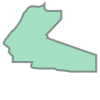

In [13]:
neighborhood_polygons[6]

## Create Dictionary Containing Names, Coordinates, and Polygons

In [14]:
neighborhood_dict = list(zip(neighborhood_names, neighborhood_coordinates, neighborhood_polygons))

## Create Points for Each Station Using Coordinates

In [15]:
# Iterate through dataframe to generate points that correspond to stations
points = []
for x in range(len(station_df)):
    point = Point(station_df['lon'][x], station_df['lat'][x])
    points.append(point)

## Iterate Through Points and Polygons to Find Matches

In [16]:
neighborhood_list = []
for point in points:
    for x in neighborhood_dict:
        if x[2].contains(point):
            n = x[0]
            neighborhood_list.append(n)
            break

## Add Neighborhood Labels to Station DataFrame

In [18]:
station_df['neighborhood'] = neighborhood_list

In [19]:
station_df.head()

,station_id,name,lat,lon,capacity,region_id,neighborhood
0,72,Georgetown Harbor / 30th St NW,38.902221,-77.059219,19,42,"Georgetown, Burleith/Hillandale"
1,91,13th St & New York Ave NW,38.900283,-77.029822,23,42,"Downtown, Chinatown, Penn Quarters, Mount Vern..."
2,106,17th & K St NW / Farragut Square,38.902061,-77.038322,35,42,"Dupont Circle, Connecticut Avenue/K Street"
3,14,19th St & Pennsylvania Ave NW,38.900300,-77.042900,15,42,"Dupont Circle, Connecticut Avenue/K Street"
4,15,14th & V St NW,38.917931,-77.032112,31,42,"Howard University, Le Droit Park, Cardozo/Shaw"


# Ride Data Investigation

In [20]:
# Bring in CSV of all rides, January 2010 - October 2019
trip_df = pd.read_csv('data/trips/all_trips.csv')

In [21]:
# Convert times to datetime
trip_df['Start date'] = pd.to_datetime(trip_df['Start date'])
trip_df['End date'] = pd.to_datetime(trip_df['End date'])

In [22]:
# Drop old index column and incorrect station numbers
trip_df.drop('Unnamed: 0', axis=1, inplace=True)
trip_df.drop(['Start station number', 'End station number'], axis=1, inplace=True)

In [23]:
trip_df.head()

,Duration,Start date,End date,Start station,End station,Bike number,Member type
0,679,2018-05-01 00:00:00,2018-05-01 00:11:19,Wisconsin Ave & Newark St NW,3000 Connecticut Ave NW / National Zoo,W22771,Member
1,578,2018-05-01 00:00:20,2018-05-01 00:09:59,7th & F St NW / National Portrait Gallery,Maine Ave & 7th St SW,W21320,Casual
2,580,2018-05-01 00:00:28,2018-05-01 00:10:09,7th & F St NW / National Portrait Gallery,Maine Ave & 7th St SW,W20863,Casual
3,606,2018-05-01 00:01:22,2018-05-01 00:11:29,Adams Mill & Columbia Rd NW,New Jersey Ave & R St NW,W00822,Member
4,582,2018-05-01 00:04:52,2018-05-01 00:14:34,15th St & Pennsylvania Ave NW/Pershing Park,3rd & Elm St NW,W21846,Member


In [24]:
trip_df.shape

(25636472, 7)

## Add Start/End Neighborhoods, Latitudes, Longitudes

In [25]:
# Merge trip dataframe and station dataframe on 'Start station' to obtain start latitude, start longitude, and start neighborhood
dc_ride_df = pd.merge(trip_df, station_df, left_on='Start station', right_on='name', copy=False)

In [26]:
# Drop unnecessary columns
dc_ride_df.drop(['station_id', 'capacity', 'Bike number', 'name'], axis=1, inplace=True)

In [27]:
# Rename columns
dc_ride_df.columns = ['duration', 'start_date', 'end_date', 'start_station', 'end_station', 'member_type', 'start_lat', 'start_lon', 'region_id', 'start_neighborhood']

In [28]:
# Merge trip dataframe and station dataframe on 'End station' to obtain end latitude, end longitude, and end neighborhood
dc_ride_df = pd.merge(dc_ride_df, station_df, left_on='end_station', right_on='name', copy=False)

In [29]:
# Drop columns not relevant to this particular exploration
dc_ride_df.drop(['station_id', 'capacity', 'name', 'region_id_y'], axis=1, inplace=True)

In [30]:
# Set column order
dc_ride_df.columns = ['duration', 'start_date', 'end_date', 'start_station', 'end_station', 'member_type', 'start_lat', 'start_lon', 'region_id', 'start_neighborhood', 'end_lat', 'end_lon', 'end_neighborhood']

## Add Distances to Trip DataFrame

In [31]:
import geopy.distance
from timeit import default_timer as timer

In [1]:
# Define function to calculate distance between starting point and ending point
def get_distance(row):
    return geopy.distance.geodesic((row['start_lat'], row['start_lon']), (row['end_lat'], row['end_lon'])).miles

In [ ]:
# Run function to calculate distances and add result as column in dataframe
start = timer()
merged_df['distance'] = merged_df.apply(get_distance, axis=1)
end = timer()
print(end - start)

## Add Day of Week and Time of Day Information

In [34]:
# Add a new column, "Day of Week", to make categorical comparisons
dc_ride_df['day_of_week'] = dc_ride_df['start_date'].dt.weekday_name

In [35]:
# Look at value counts of new column
dc_ride_df.day_of_week.value_counts()

Friday       3238900
Wednesday    3221453
Thursday     3201172
Saturday     3159470
Tuesday      3128318
Monday       2987128
Sunday       2889453
Name: day_of_week, dtype: int64

In [36]:
# Add a similar categorical column, "Start Hour"
dc_ride_df['start_hour'] = dc_ride_df['start_date'].dt.hour

## Day of Week and Time of Day Aggregation

In [38]:
weekday_agg_rides_by_hour = dc_ride_df[['day_of_week', 'start_hour', 'duration']].loc[dc_ride_df['day_of_week'].isin(['Monday', "Tuesday", "Wednesday", "Thursday", "Friday"])].groupby(['start_hour']).count()

In [39]:
weekend_agg_rides_by_hour = dc_ride_df[['day_of_week', 'start_hour', 'duration']].loc[dc_ride_df['day_of_week'].isin(['Saturday', 'Sunday'])].groupby(['start_hour']).count()

In [44]:
df1 = dc_ride_df[["start_date", 'day_of_week', 'start_hour', 'duration']].loc[dc_ride_df['day_of_week'].isin(['Monday', "Tuesday", "Wednesday", "Thursday", "Friday"])]
df1["start_date"] = pd.to_datetime(df1["start_date"])

In [45]:
df2 = df1.groupby(["start_hour", pd.Grouper(key='start_date', freq='H')])["day_of_week"].count()
df3 = df2.groupby("start_hour").mean()

## Import and Clean Weather Data

In [49]:
# Bring in historical weather data from NOAA (National Oceanic and Atmospheric Administration)
weather_df = pd.read_csv('data/weather/dc_weather.csv')

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (33,34,41,42,43,46,49,51,52,58,59,69,73,75,76,88,89) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [50]:
# Choose three columns; date, precipitation, and temperature
select_weather_df = weather_df[['DATE', 'HourlyPrecipitation', 'HourlyDryBulbTemperature']]

In [51]:
# View object types
select_weather_df.dtypes

DATE                        object
HourlyPrecipitation         object
HourlyDryBulbTemperature    object
dtype: object

In [52]:
# Inspect length
len(select_weather_df)

143775

In [53]:
# Drop all rows with empty values
select_weather_df = select_weather_df.dropna()

In [54]:
# Inspect length
len(select_weather_df)

100145

In [55]:
# Convert HourlyPrecipitation into a categorical variable-- N: no rain; T: trace amounts of rain; Y: rain
rain_cat = []
for x in select_weather_df.HourlyPrecipitation:
    if x == '0.00':
        rain_cat.append('N')
        continue
    if x == 0:
        rain_cat.append('N')
        continue
    if x == 'T':
        rain_cat.append('T')
        continue
    else:
        rain_cat.append('Y')

In [56]:
# Add new categorical variable to dataframe
select_weather_df['precip_cat'] = rain_cat

In [57]:
# Add column to dataframe, datetimes from DATE column
select_weather_df['start_date'] = pd.to_datetime(select_weather_df['DATE'])

In [58]:
# Drop original precipitation and date columns
select_weather_df.drop('HourlyPrecipitation', axis=1, inplace=True)
select_weather_df.drop('DATE', axis=1, inplace=True)

In [59]:
# Import regex to clean up temperature data, which includes non-numeric characters
import re

In [60]:
# Select only integers and floats
select_weather_df['HourlyDryBulbTemperature']= [re.sub(r'[^0-9.,]+','', str(x)) for x in select_weather_df['HourlyDryBulbTemperature']]

In [61]:
# Convert temperature values to numbers and round to the nearest whole number
select_weather_df['HourlyDryBulbTemperature'] = pd.to_numeric(select_weather_df.HourlyDryBulbTemperature)
select_weather_df['HourlyDryBulbTemperature'] = select_weather_df.HourlyDryBulbTemperature.round()

## Add Weather Data to Ride DataFrame

In [62]:
# Sort ride dataframe and weather dataframe by time
dc_ride_df.sort_values('start_date', inplace=True)
select_weather_df.sort_values('start_date', inplace=True)

In [63]:
# Use 'merge_asof' to merge dataframes
merged_df = pd.merge_asof(dc_ride_df, select_weather_df, on='start_date')